In [1]:
from pandas_datareader.data import DataReader
import requests_cache
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas_ta as pta

### Scrapping & Preparing Data from Web

In [2]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

def get_adj_close(tickers, start_date, end_date):
    returns_df = pd.DataFrame()
    for ticker in tickers:
        # retrieve stock data (includes Date, OHLC, Volume, Adjusted Close)
        try:
          s = DataReader(ticker, 'yahoo', start_date, end_date, session=session)
          returns_df[ticker] = s['Adj Close']
        except:
          print(ticker)
    return returns_df

In [3]:
data = pd.read_csv('C:\\Users\\Guo Xiong\\Documents\\Y3S1\\BT4222\\Project\\P&G Final.csv')
data = data.sort_values(by = 'Date')
data['Sentiment'] = data.apply(lambda x:x['probability'] if x['sentiment'] =='POSITIVE' else -x['probability'],axis=1)
data = data.drop(['probability', 'sentiment'], axis=1)
data.head(2).append(data.tail(2))

,Date,Text,neg,neu,pos,compound,0,1,2,3,4,5,6,7,8,9,Sentiment
3594,2006-12-05,Time Warner was banking on a huge turnout for ...,0.000,0.791,0.209,0.8934,0.352041,0.000000,0.000000,0.523501,0.000000,0.000000,0.119822,0.000000,0.0,0.000000,-0.993051
4475,2006-12-11,There will be plenty of news for investors to ...,0.000,1.000,0.000,0.0000,0.141898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567705,0.0,0.285761,0.514518
0,2021-11-04,"InvestorPlace - Stock Market News, Stock Advic...",0.025,0.867,0.108,0.9987,0.035151,0.060993,0.316326,0.459481,0.011599,0.000000,0.078485,0.000000,0.0,0.037911,0.923506
4396,2021-11-10,“Halftime Report” trader Pete Najarian spots u...,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.180322,0.607812,0.000000,0.200391,0.0,0.000000,-0.912835


In [4]:
PG_start_date = '2016-01-01'  # Using earlier dates for calculation of SMA later
PG_end_date = '2020-01-28'

In [5]:
PG_data = DataReader('PG', 'yahoo', PG_start_date, PG_end_date)
PG_data.columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
PG_data['Close'] = PG_data['Close'].shift(-1)    # for predicting tomorrow's close price
PG_data = PG_data[:-1]
PG_data['Movement'] = np.where(PG_data['Close'] > PG_data['Close'].shift(1),1,0)
PG_data['price_diff'] = PG_data['Close'].diff()
PG_data['TNX'] = DataReader('^TNX', 'yahoo', PG_start_date, PG_end_date)['Close']
#PG_data['Movement'] = np.where(PG_data['Close'] < PG_data['Close'].shift(-1),1,0)
#PG_data['price_diff'] = PG_data['Close'].diff().shift(-1)
PG_data.head(5).append(PG_data.tail(5))

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX
Date,,,,,,,,,
2015-12-31,80.040001,79.309998,79.910004,78.370003,5077700.0,66.678078,0,NaN,2.269
2016-01-04,78.500000,77.540001,78.360001,78.620003,11529800.0,65.804810,1,0.250000,2.245
2016-01-05,78.959999,78.209999,78.440002,77.860001,8133700.0,66.014725,0,-0.760002,2.248
2016-01-06,78.290001,77.120003,77.669998,77.180000,9551000.0,65.376572,0,-0.680000,2.177
2016-01-07,77.599998,76.070000,76.849998,75.970001,11973900.0,64.805588,0,-1.209999,2.153
2020-01-21,126.620003,124.839996,126.410004,126.309998,8553100.0,120.031807,1,0.220001,1.769
2020-01-22,126.680000,125.830002,126.330002,124.989998,7396700.0,120.241219,0,-1.320000,1.769
2020-01-23,126.550003,123.650002,124.300003,125.139999,11096500.0,119.691566,1,0.150002,1.740
2020-01-24,126.790001,124.769997,125.220001,125.690002,9508600.0,119.835205,1,0.550003,1.681


In [6]:
#SMA
PG_data['SMA20'] = PG_data['Close'].rolling(window=20).mean() 
PG_data['SMA50'] = PG_data['Close'].rolling(window=50).mean() 
PG_data['SMA100'] = PG_data['Close'].rolling(window=100).mean() 

#EMA
PG_data['EMA10'] = PG_data['Close'].ewm(span=10, adjust=False).mean() 
PG_data['EMA20'] = PG_data['Close'].ewm(span=20, adjust=False).mean() 
PG_data['EMA40'] = PG_data['Close'].ewm(span=40, adjust=False).mean() 

#MACD
exp1 = PG_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = PG_data['Close'].ewm(span=26, adjust=False).mean()
PG_data['MACD'] = exp1-exp2
PG_data['Signal'] = PG_data['MACD'].ewm(span=9, adjust=False).mean()

#RSI 
PG_data['RSI'] = pta.rsi(PG_data['Close'], length = 14)

In [7]:
PG_data

,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,
2015-12-31,80.040001,79.309998,79.910004,78.370003,5077700.0,66.678078,0,NaN,2.269,NaN,NaN,NaN,78.370003,78.370003,78.370003,0.000000,0.000000,NaN
2016-01-04,78.500000,77.540001,78.360001,78.620003,11529800.0,65.804810,1,0.250000,2.245,NaN,NaN,NaN,78.415457,78.393812,78.382198,0.019943,0.003989,NaN
2016-01-05,78.959999,78.209999,78.440002,77.860001,8133700.0,66.014725,0,-0.760002,2.248,NaN,NaN,NaN,78.314465,78.342973,78.356725,-0.025286,-0.001866,NaN
2016-01-06,78.290001,77.120003,77.669998,77.180000,9551000.0,65.376572,0,-0.680000,2.177,NaN,NaN,NaN,78.108199,78.232214,78.299324,-0.114679,-0.024429,NaN
2016-01-07,77.599998,76.070000,76.849998,75.970001,11973900.0,64.805588,0,-1.209999,2.153,NaN,NaN,NaN,77.719436,78.016765,78.185698,-0.279934,-0.075530,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21,126.620003,124.839996,126.410004,126.309998,8553100.0,120.031807,1,0.220001,1.769,124.6135,123.4618,122.6142,125.386515,124.831517,124.100952,0.639286,0.412731,61.399430
2020-01-22,126.680000,125.830002,126.330002,124.989998,7396700.0,120.241219,0,-1.320000,1.769,124.6180,123.5676,122.6523,125.314421,124.846610,124.144320,0.572300,0.444645,52.391421
2020-01-23,126.550003,123.650002,124.300003,125.139999,11096500.0,119.691566,1,0.150002,1.740,124.6140,123.6838,122.7014,125.282708,124.874552,124.192890,0.525261,0.460768,53.231128


In [8]:
PG_data = PG_data.reset_index()
PG_data['Date'] = PG_data['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S")[:10]) #transform from datetime64 to date object
PG_data = PG_data.iloc[99:]     # dropping first 99 columns for NA SMA100
PG_data.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Movement,price_diff,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
99,2016-05-24,81.379997,80.300003,80.300003,81.480003,6293300.0,69.142334,1,0.510002,1.859,81.116501,81.889801,81.0003,80.897566,81.110474,81.367087,-0.281880,-0.279944,51.835397
100,2016-05-25,81.769997,81.010002,81.080002,81.220001,6049800.0,69.577843,0,-0.260002,1.870,81.189501,81.887401,81.0288,80.956190,81.120905,81.359912,-0.238627,-0.271681,49.873590
101,2016-05-26,81.599998,81.089996,81.480003,81.430000,4622300.0,69.355812,1,0.209999,1.823,81.255001,81.861001,81.0569,81.042338,81.150343,81.363331,-0.185268,-0.254398,51.471142
102,2016-05-27,81.660004,81.160004,81.269997,81.040001,4322200.0,69.535133,0,-0.389999,1.851,81.258501,81.818801,81.0887,81.041913,81.139834,81.347559,-0.172462,-0.238011,48.386907
103,2016-05-31,81.820000,80.739998,81.580002,81.790001,6705000.0,69.202103,1,0.750000,1.834,81.293001,81.788201,81.1348,81.177929,81.201755,81.369141,-0.100634,-0.210536,54.084892


In [9]:
PG_merged = pd.merge(data, PG_data, left_on = 'Date', right_on = 'Date', how = 'inner')
PG_merged

,Date,Text,neg,neu,pos,compound,0,1,2,3,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
0,2016-05-24,Energizer lawsuit over Duracell s pink bunny c...,0.158,0.583,0.258,0.2960,0.978049,0.000000,0.000000,0.000000,...,1.859,81.116501,81.889801,81.0003,80.897566,81.110474,81.367087,-0.281880,-0.279944,51.835397
1,2016-05-31,The Golden State Warriors and the Cleveland Ca...,0.056,0.899,0.045,-0.1280,0.000000,0.000000,0.000000,0.500587,...,1.834,81.293001,81.788201,81.1348,81.177929,81.201755,81.369141,-0.100634,-0.210536,54.084892
2,2016-05-31,The wealth of information on the internet has ...,0.000,0.900,0.100,0.6378,0.501735,0.000000,0.000000,0.123310,...,1.834,81.293001,81.788201,81.1348,81.177929,81.201755,81.369141,-0.100634,-0.210536,54.084892
3,2016-06-01,Procter Gamble Names David S Taylor Chairma...,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.223115,0.000000,...,1.846,81.310501,81.772401,81.1946,81.318305,81.273016,81.397476,-0.030449,-0.174518,55.220614
4,2016-06-01,Stock Market News For June 02 2016,0.000,1.000,0.000,0.0000,0.000000,0.970968,0.000000,0.000000,...,1.846,81.310501,81.772401,81.1946,81.318305,81.273016,81.397476,-0.030449,-0.174518,55.220614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835,2020-01-24,Beauty Product Wins Propel Another Procter G...,0.000,0.483,0.517,0.8176,0.000000,0.172877,0.581033,0.000000,...,1.681,124.637500,123.812200,122.7447,125.356762,124.952214,124.265920,0.526297,0.473874,56.276312
1836,2020-01-24,"InvestorPlace - Stock Market News, Stock Advic...",0.040,0.775,0.185,0.9990,0.000000,0.118900,0.200786,0.429732,...,1.681,124.637500,123.812200,122.7447,125.356762,124.952214,124.265920,0.526297,0.473874,56.276312
1837,2020-01-24,Bankrupt California power producer PG&E said o...,0.114,0.803,0.082,-0.3818,0.282153,0.169115,0.000000,0.161812,...,1.681,124.637500,123.812200,122.7447,125.356762,124.952214,124.265920,0.526297,0.473874,56.276312
1838,2020-01-24,"InvestorPlace - Stock Market News, Stock Advic...",0.021,0.825,0.154,0.9998,0.054461,0.014885,0.000000,0.501971,...,1.681,124.637500,123.812200,122.7447,125.356762,124.952214,124.265920,0.526297,0.473874,56.276312


In [10]:
PG_merged.columns

Index(['Date', 'Text', 'neg', 'neu', 'pos', 'compound', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', 'Sentiment', 'High', 'Low', 'Open',
       'Close', 'Volume', 'Adj Close', 'Movement', 'price_diff', 'TNX',
       'SMA20', 'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal',
       'RSI'],
      dtype='object')

In [11]:
test  = PG_merged.copy()
test = test.groupby('Date').mean()
test['Movement'].unique()

array([1, 0])

In [12]:
test.isnull().sum()

neg           0
neu           0
pos           0
compound      0
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7             0
8             0
9             0
Sentiment     0
High          0
Low           0
Open          0
Close         0
Volume        0
Adj Close     0
Movement      0
price_diff    0
TNX           5
SMA20         0
SMA50         0
SMA100        0
EMA10         0
EMA20         0
EMA40         0
MACD          0
Signal        0
RSI           0
dtype: int64

In [13]:
test[test.isnull().any(axis=1)].iloc[:,5:]

,1,2,3,4,5,6,7,8,9,Sentiment,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-24,0.177195,0.000000,0.000000,0.000000,0.118203,0.402512,0.000000,0.000000,0.292889,-0.017186,...,NaN,87.7825,89.9130,90.439700,88.470197,88.462844,89.075733,-0.202276,-0.457451,52.290021
2018-07-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.978049,0.000000,-0.860663,...,NaN,77.2135,74.7810,76.771200,77.873809,77.100855,76.368248,0.946796,0.829766,66.957714
2018-12-24,0.074384,0.323656,0.319048,0.000000,0.000000,0.000000,0.108867,0.000000,0.145507,0.071346,...,NaN,92.8105,90.7540,86.815600,91.376873,91.980512,91.140082,-0.251962,0.511504,44.102708
2019-07-03,0.217485,0.042613,0.486409,0.009669,0.000000,0.084589,0.068500,0.000000,0.036287,-0.998664,...,NaN,110.7510,107.7002,104.773901,111.531150,110.464980,108.788167,1.390133,1.275891,63.423310
2019-11-29,0.000000,0.615693,0.000000,0.203452,0.000000,0.000000,0.000000,0.170119,0.000000,0.002474,...,NaN,120.6720,121.5516,119.925700,121.591709,121.345843,121.150966,0.204068,-0.012333,56.539571


In [14]:
test = test[-test.isnull().any(axis=1)]     # removing the NA TNX rows
test.head(2).append(test.tail(2))

,neg,neu,pos,compound,0,1,2,3,4,5,...,TNX,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,0.158000,0.58300,0.2580,0.296000,0.978049,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.859,81.116501,81.889801,81.0003,80.897566,81.110474,81.367087,-0.281880,-0.279944,51.835397
2016-05-31,0.028000,0.89950,0.0725,0.254900,0.250867,0.000000,0.000000,0.311948,0.053186,0.000000,...,1.834,81.293001,81.788201,81.1348,81.177929,81.201755,81.369141,-0.100634,-0.210536,54.084892
2020-01-23,0.071143,0.85281,0.0760,0.231352,0.071545,0.170566,0.480250,0.070760,0.047313,0.027149,...,1.740,124.614000,123.683800,122.7014,125.282708,124.874552,124.192890,0.525261,0.460768,53.231128
2020-01-24,0.044000,0.75240,0.2034,0.675880,0.088324,0.120826,0.163147,0.274960,0.033150,0.016310,...,1.681,124.637500,123.812200,122.7447,125.356762,124.952214,124.265920,0.526297,0.473874,56.276312


In [15]:
test['compound_score_mod'] =  test['compound']*test['SMA20']
test.head(15)

,neg,neu,pos,compound,0,1,2,3,4,5,...,SMA20,SMA50,SMA100,EMA10,EMA20,EMA40,MACD,Signal,RSI,compound_score_mod
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-24,0.1580,0.5830,0.2580,0.29600,0.978049,0.000000,0.000000,0.000000,0.000000,0.000000,...,81.116501,81.889801,81.0003,80.897566,81.110474,81.367087,-0.281880,-0.279944,51.835397,24.010484
2016-05-31,0.0280,0.8995,0.0725,0.25490,0.250867,0.000000,0.000000,0.311948,0.053186,0.000000,...,81.293001,81.788201,81.1348,81.177929,81.201755,81.369141,-0.100634,-0.210536,54.084892,20.721586
2016-06-01,0.0000,1.0000,0.0000,0.00000,0.000000,0.485484,0.111557,0.000000,0.242930,0.000000,...,81.310501,81.772401,81.1946,81.318305,81.273016,81.397476,-0.030449,-0.174518,55.220614,0.000000
2016-06-03,0.0940,0.8370,0.0690,-0.29600,0.902676,0.000000,0.000000,0.000000,0.000000,0.000000,...,81.401001,81.763001,81.3152,81.753575,81.518727,81.514194,0.165397,-0.067993,60.732410,-24.094696
2016-06-06,0.0000,1.0000,0.0000,0.00000,0.000000,0.225104,0.000000,0.000000,0.000000,0.000000,...,81.411000,81.757001,81.3799,81.856562,81.595039,81.553502,0.205202,-0.013354,56.432528,0.000000
2016-06-07,0.0000,0.8935,0.1065,0.44620,0.405366,0.000000,0.042805,0.068689,0.000000,0.000000,...,81.419500,81.754001,81.4449,82.000823,81.695511,81.606989,0.260374,0.041391,58.739599,36.329381
2016-06-08,0.0000,0.8970,0.1030,0.65900,0.112680,0.000000,0.371453,0.000000,0.000000,0.000000,...,81.470500,81.763801,81.5268,82.213401,81.835939,81.683234,0.342114,0.101536,62.141566,53.689060
2016-06-14,0.0000,1.0000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.434810,0.539384,...,81.779499,81.761000,81.7811,82.658059,82.225947,81.925187,0.456381,0.297642,57.395251,0.000000
2016-06-15,0.0384,0.7760,0.1852,0.66272,0.090651,0.144277,0.204365,0.171109,0.041048,0.112562,...,81.957500,81.753000,81.8467,82.794776,82.338714,81.997617,0.491422,0.336398,60.464888,54.314874


<AxesSubplot:xlabel='Date'>

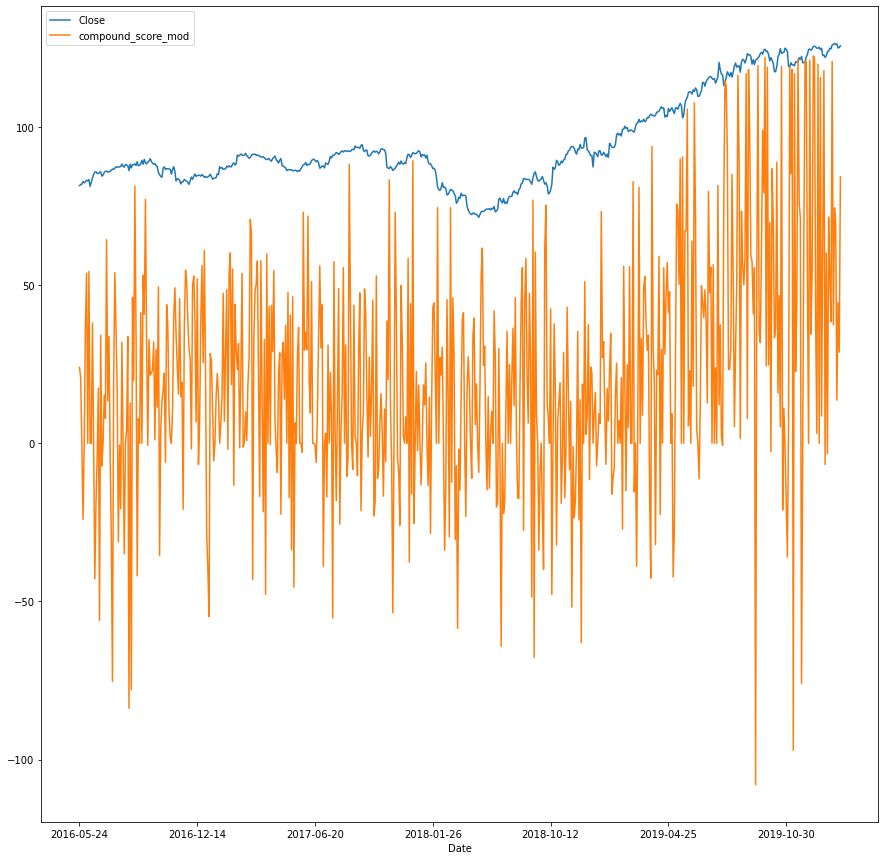

In [16]:
test[['Close', 'compound_score_mod']].plot(figsize = (15,15))

In [17]:
test1 = test.copy()

<AxesSubplot:xlabel='Date'>

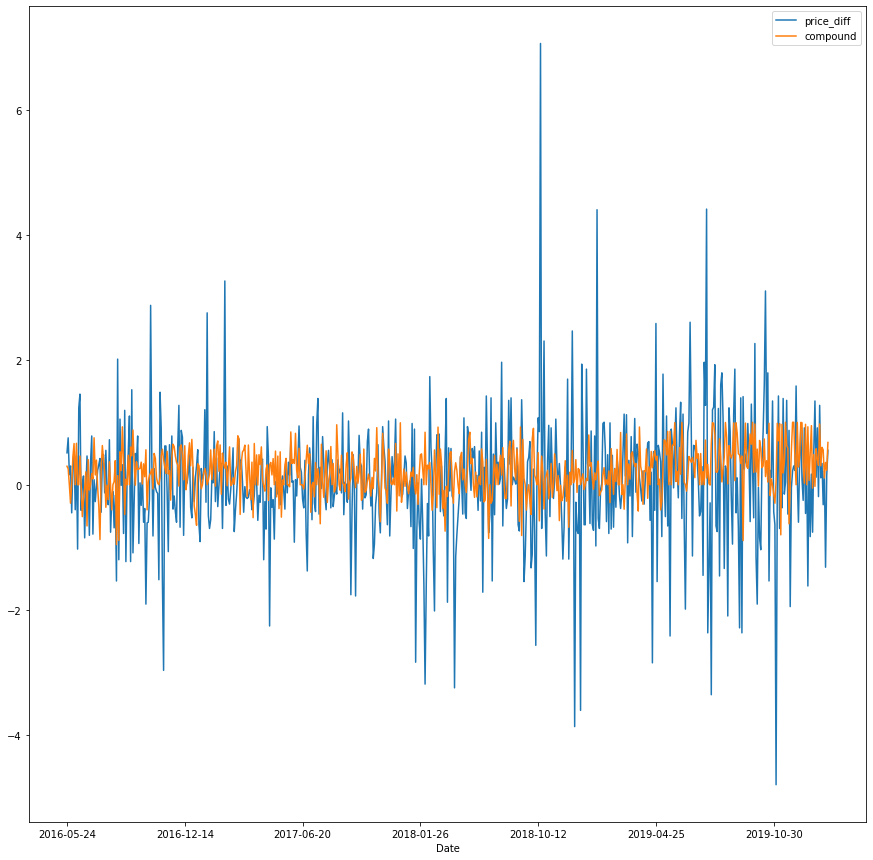

In [18]:
test1[['price_diff', 'compound']].plot(figsize = (15,15))

In [19]:
test1['same_sign'] = test1['price_diff']*test1['compound'] > 0 
print(test1['same_sign'].sum())
print(len(test1))

314
647


### Linear Regression

In [20]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from random import seed

In [21]:
seed(4222)
xvar, yvar = test1[['SMA20', 'SMA50', 'SMA100']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

In [22]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

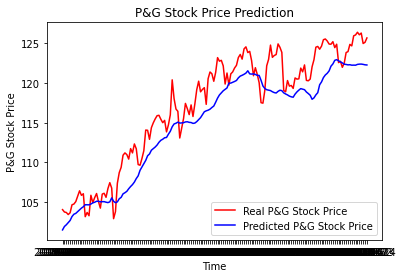

Mean squared error: 8.430
Coefficient of determination: 0.833
Adjusted R Squared: 0.830


In [23]:
pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

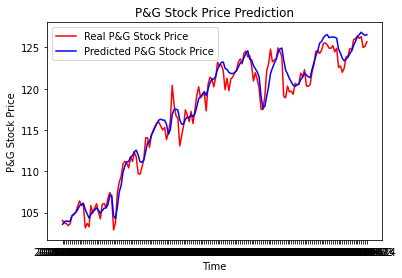

Mean squared error: 1.312
Coefficient of determination: 0.974
Adjusted R Squared: 0.974


In [24]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

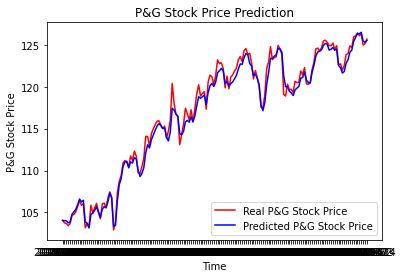

Mean squared error: 0.512
Coefficient of determination: 0.990
Adjusted R Squared: 0.989


In [25]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

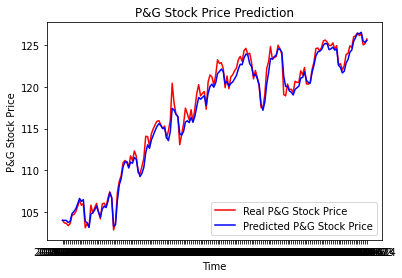

Mean squared error: 0.532
Coefficient of determination: 0.989
Adjusted R Squared: 0.989


In [26]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'TNX', 'Volume']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

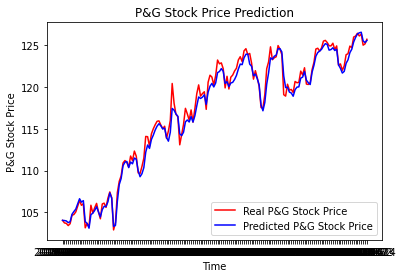

Mean squared error: 0.512
Coefficient of determination: 0.990
Adjusted R Squared: 0.989


In [27]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

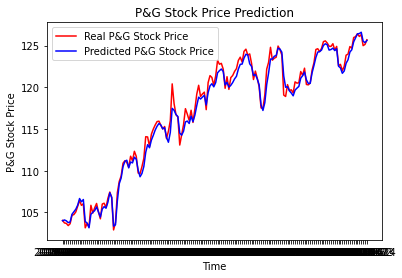

Mean squared error: 0.490
Coefficient of determination: 0.990
Adjusted R Squared: 0.989


In [40]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', '0','1','2','3','4','5','6','7','8','9']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

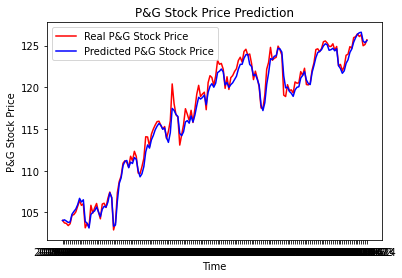

Mean squared error: 0.490
Coefficient of determination: 0.990
Adjusted R Squared: 0.989


In [39]:
seed(4222)
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'neg', 'neu', 'pos', 'compound', '0','1','2','3','4','5','6','7','8','9']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)
y_pred = linear_regression.predict(x_test)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.3f" % metrics.mean_squared_error(y_test, y_pred))  # It is the average of the squared difference between the predicted and actual value.
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))  # This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable.
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

In [29]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

In [30]:
test.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Sentiment', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Adj Close', 'Movement', 'price_diff', 'TNX', 'SMA20', 'SMA50',
       'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [31]:
test2 = test.drop('Close', inplace=False, axis=1)    # inplace=False means the operation would not work on the original object. axis=1 means we are dropping the column, not the row.
test2.drop('Adj Close', inplace=True, axis=1)
test2.drop('price_diff', inplace=True, axis=1)
test2.drop('Movement', inplace=True, axis=1)
test2.drop('High', inplace=True, axis=1)
test2.drop('Low', inplace=True, axis=1)
test2.columns

Index(['neg', 'neu', 'pos', 'compound', '0', '1', '2', '3', '4', '5', '6', '7',
       '8', '9', 'Sentiment', 'Open', 'Volume', 'TNX', 'SMA20', 'SMA50',
       'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI',
       'compound_score_mod'],
      dtype='object')

In [32]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
forward_selection = sfs(classifier, n_features_to_select = 10, direction='forward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
forward_selection = forward_selection.fit(x_train, y_train)

test2.columns[forward_selection.support_]

Index(['Open', 'SMA20', 'SMA50', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

In [33]:
classifier = linear_model.LinearRegression()
xvar, yvar = test2, test1['Close']
x_train, x_test, y_train, y_test = train_test_split(xvar, yvar, test_size=0.25, random_state=0)

# Build step forward feature selection
backward_selection = sfs(classifier, n_features_to_select = 10, direction='backward', scoring='neg_mean_squared_error', cv=3)

# Perform SFFS
backward_selection = backward_selection.fit(x_train, y_train)

test2.columns[backward_selection.support_]

Index(['4', 'Open', 'SMA20', 'SMA100', 'EMA10', 'EMA20', 'EMA40', 'MACD',
       'Signal', 'RSI'],
      dtype='object')

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

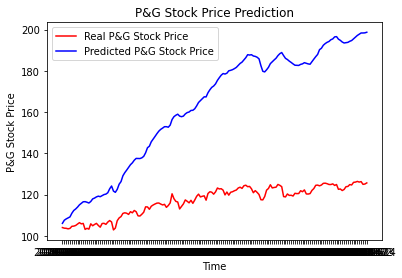

Mean squared error: 2549.31
Coefficient of determination: -49.503
Adjusted R Squared: -50.462


In [41]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

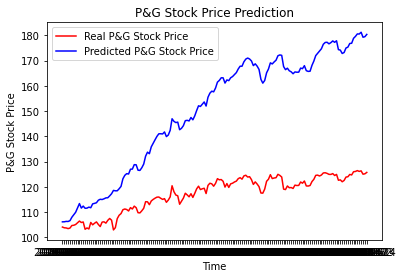

Mean squared error: 1344.10
Coefficient of determination: -25.628
Adjusted R Squared: -26.658


In [42]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))

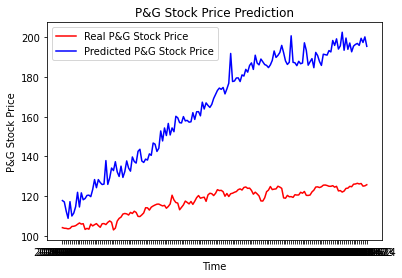

Mean squared error: 2660.39
Coefficient of determination: -51.704
Adjusted R Squared: -55.195


In [43]:
xvar, yvar = test1[['EMA10', 'EMA20', 'EMA40', 'MACD', 'Signal', 'RSI', 'neg', 'neu', 'pos', 'compound']], test1['Close']
x_train, y_train = xvar[:int(0.75*len(xvar))], yvar[:int(0.75*len(yvar))]
x_test, y_test = xvar[int(0.75*len(xvar)):], yvar[int(0.75*len(yvar)):]

scaler = StandardScaler()
scaler.fit(x_train)     # Only fit scaler to training dataset as test dataset is unseen data
xscaled = scaler.transform(x_train)     # feature scaling is needed for Gradient Descent Based Algorithms - neural netorks (to ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features)
numdim = len(xvar.columns)
kerasmodel = Sequential()
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(10, input_dim=numdim, kernel_initializer='normal', activation='relu'))
kerasmodel.add(Dense(1, kernel_initializer='normal'))
kerasmodel.compile(loss='mean_squared_error', optimizer='adam')
kerasmodel.fit(xscaled, y_train, epochs=50, batch_size=10, verbose=0)

xtestscaled = scaler.transform(x_test)
y_pred = kerasmodel.predict(xtestscaled)

pyplot.plot(y_test, color = 'red', label = 'Real P&G Stock Price')
pyplot.plot(y_pred, color = 'blue', label = 'Predicted P&G Stock Price')
pyplot.title('P&G Stock Price Prediction')
pyplot.xlabel('Time')
pyplot.ylabel('P&G Stock Price')
pyplot.legend()
pyplot.show()

print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test, y_pred))  
print("Coefficient of determination: %.3f" % metrics.r2_score(y_test, y_pred))
print("Adjusted R Squared: %.3f" % (1 - (1-metrics.r2_score(y_test, y_pred)) * (len(y_test)-1) / (len(y_test)-x_test.shape[1]-1) ))